# Exercise 13-1

### DSC530
#### Taniya Adhikari
##### 11/21/2020



In [85]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [86]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [87]:
resp6 = nsfg.ReadFemResp()

In [88]:
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6['agemarry'] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6['age'] = (resp6.cmintvw - resp6.cmbirth) / 12.0

In [89]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [90]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [91]:
# resamples the data from the cleaned married data
def ResampleDivorceCurve(resps):
    for _ in range(11):
        samplesWeighted = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samplesWeighted, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',    # plots the resampled data
                   axis=[0, 28, 0, 1])

In [92]:
def survivalEst(resp):
    ended = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(ended, ongoing)
    sf = hf.MakeSurvival()
    
    # returns hazard and survival functions
    return hf, sf

In [93]:
# plots survival curve and group respondents by decades
def decadeSurvivalEst(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = survivalEst(group)
        thinkplot.Plot(sf, **options)

In [94]:
# plots divorce curve by decade
# Calls decadeSurvivalEst function which gets survival estimates by decades
def divorceDecadeCurve(resps):
    # takes the resampled rows from the respand creats a sample df.
    for i in range(41):
        samplesWeighted = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samplesWeighted, ignore_index=True)
        
        # Group the above sample by decade
        decadeGroups = sample.groupby('decade')
        
        # creates label for decades
        if i == 0:
            survival.AddLabelsByDecade(decadeGroups, alpha=0.7)

        decadeSurvivalEst(decadeGroups, alpha=0.1)
    # plots the surived mariages fraction
    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction Survived Marriage',
                     axis=[0, 30, 0, 1])

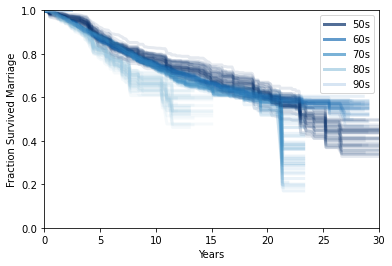

In [95]:
divorceDecadeCurve([married6, married7])